In [13]:
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
  
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
!wget https://github.com/SpringerNLP/Chapter3.git

--2022-06-19 08:51:03--  https://github.com/SpringerNLP/Chapter3.git
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/SpringerNLP/Chapter3 [following]
--2022-06-19 08:51:03--  https://github.com/SpringerNLP/Chapter3
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Chapter3.git’

Chapter3.git            [ <=>                ] 152.55K  --.-KB/s    in 0.04s   

2022-06-19 08:51:04 (4.07 MB/s) - ‘Chapter3.git’ saved [156214]



In [11]:
!git clone https://github.com/SpringerNLP/Chapter3.git

Cloning into 'Chapter3'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


In [14]:
filelist = ['reuters-000.json',
            'reuters-001.json',
            'reuters-002.json',
            'reuters-003.json',
            'reuters-004.json',
            'reuters-005.json',
            'reuters-006.json',
            'reuters-007.json',
            'reuters-008.json',
            'reuters-009.json',
            'reuters-010.json',
            'reuters-011.json',
            'reuters-012.json',
            'reuters-013.json',
            'reuters-014.json',
            'reuters-015.json',
            'reuters-016.json',
            'reuters-017.json',
            'reuters-018.json',
            'reuters-019.json',
            'reuters-020.json',
            'reuters-021.json']
data_set = pd.DataFrame()
for fname in filelist:
  df = pd.read_json('Chapter3/data/reuters-21578-json/'+fname).T
  data_set = data_set.append(df)
  
data_set = data_set.fillna('')
print("Done!") 

Done!


#Task 1: EDA

documents with at least one topic =  1076
max number of topics in one document =  16
topics =  64
places =  92
organizations =  11


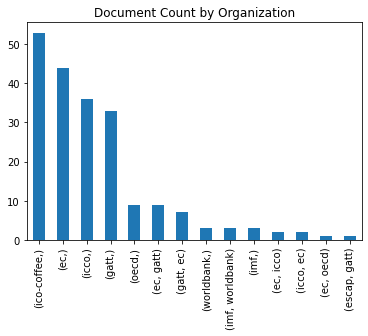

In [17]:
topics = set([x for sublist in data_set[u'topics'].values.tolist() for x in sublist])
places = set([x for sublist in data_set[u'places'].values.tolist() for x in sublist])
orgs = set([x for sublist in data_set[u'organisations'].values.tolist() for x in sublist])

data_set['topic_count']=data_set[u'topics'].apply(lambda x:len([y for y in x]))
print("documents with at least one topic = ",len(data_set[data_set[u'topic_count']>0]))
print("max number of topics in one document = ",data_set[u'topic_count'].max())
print('topics = ',len(topics))
print('places = ',len(places))
print('organizations = ',len(orgs))

data_set[u'organisations'].apply(tuple).value_counts()[1:15].plot(kind='bar',title="Document Count by Organization")

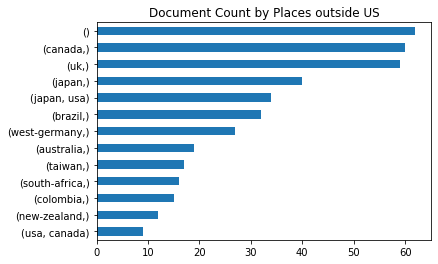

In [18]:
data_set[u'places'].apply(tuple).value_counts()[2:15].sort_values().plot(kind='barh',title='Document Count by Places outside US')

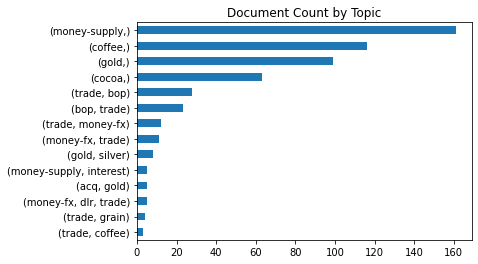

In [19]:
data_set[u'topics'].apply(tuple).value_counts()[1:15].sort_values().plot(kind='barh',title='Document Count by Topic')

In [15]:
nltk .download("punkt") 
nltk.download("stopwords","data") 
nltk.data.path.append('data')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
data_set.head()

,title,body,date,topics,places,organisations,topic_count
1,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,26-FEB-1987 15:01:01.79,[cocoa],"[el-salvador, usa, uruguay]",,1
30,ASSETS OF MONEY MARKET MUTUAL FUNDS ROSE 720.4...,,26-FEB-1987 15:41:56.54,[money-supply],,,1
42,ICO PRODUCERS TO PRESENT NEW COFFEE PROPOSAL,"International Coffee Organization, ICO,\nprodu...",26-FEB-1987 15:49:27.16,[coffee],[uk],[ico-coffee],1
47,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation\nplan, initially hailed at home and ...",26-FEB-1987 15:51:51.24,[trade],[brazil],,1
58,ASSETS OF U.S. MONEY FUNDS ROSE IN WEEK,Assets of money market mutual funds\nincreased...,26-FEB-1987 15:58:19.46,[money-supply],[usa],,1


In [22]:
labelBinarizer = MultiLabelBinarizer ()
data_target = labelBinarizer.fit_transform(data_set[u'topics'])

stopWords = stopwords.words('english') #All the stop words
charfilter = re.compile('[a-zA-Z]+') #Words

def SimpleTokenizer(text):
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words if word not in stopWords] # word list without stopwords
    tokens= (list(map(lambda token: PorterStemmer().stem(token), words))) #stemming by porterstemming method
    ntokens = list(filter(lambda token: charfilter.match(token), tokens))
    return ntokens

vec = TfidfVectorizer(tokenizer=SimpleTokenizer, max_features=1000, norm='l2')
mytopics = [u'cocoa', u'trade', u'money-supply', u'coffee', u'gold']
data_set = data_set[data_set[u'topics'].map(set(mytopics).intersection).apply(lambda x: len(x) > 0)]
docs = list(data_set[u'body'].values)
dtm = vec.fit_transform(docs)


In [23]:
print("Number of documents with my topics = ",len(data_set))

Number of documents with my topics =  1076


#Text Clustering

Text(0, 0.5, 'Proportion of Explained Variance')

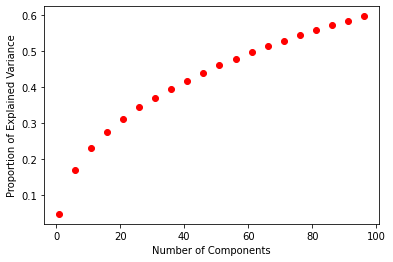

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

explained_var = []
for components in range(1,100,5):
  pca = PCA(n_components=components)
  pca.fit(dtm.toarray())
  explained_var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1,100,5),explained_var,"ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

Explained variance of the PCA step: 49%


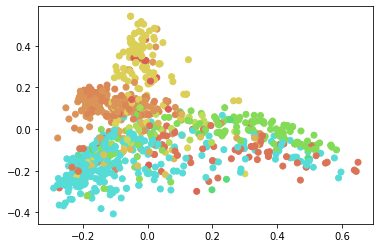

In [28]:
from sklearn.decomposition import PCA
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))

pca = PCA(n_components=components)
pca.fit(dtm.toarray())
pca_dtm = pca.transform(dtm.toarray())
data_target = labelBinarizer.fit_transform(data_set[u'topics'])
plt.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(
    int(explained_variance * 100)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


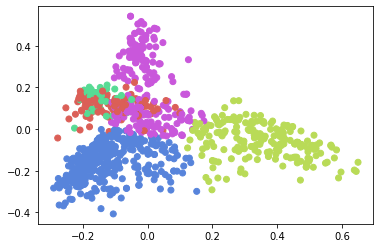

In [29]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 5))

model = KMeans(n_clusters=5,max_iter=100)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y.astype(np.int)])

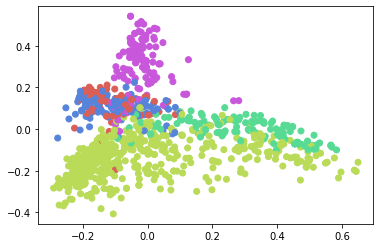

In [30]:
palette = np.array(sns.color_palette("hls", 5))

gold_labels = data_set['topics'].map(set(mytopics).intersection).apply(lambda x: x.pop()).apply(lambda x: mytopics.index(x))

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[gold_labels])

#Topic Modeling

##LSA

Explained variance of the SVD step: 49%


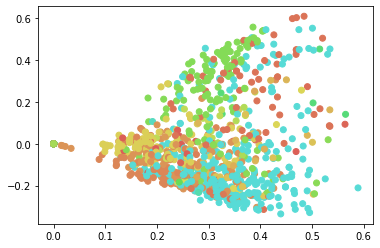

In [31]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

components = 60

palette = np.array(sns.color_palette("hls", 120))

lsa = TruncatedSVD(n_components=components)
lsa.fit(dtm)
lsa_dtm = lsa.transform(dtm)

plt.scatter(lsa_dtm[:,0],lsa_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = lsa.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


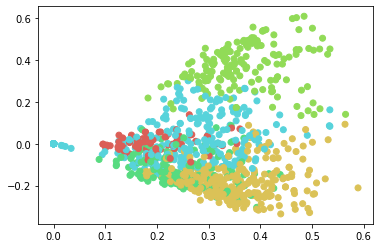

In [32]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 8))

model = KMeans(n_clusters=5,max_iter=100)
clustered = model.fit(lsa_dtm)
centroids = model.cluster_centers_
y = model.predict(lsa_dtm)

ax = plt.subplot()
sc = ax.scatter(lsa_dtm[:,0],lsa_dtm[:,1],c=palette[y.astype(np.int)])

In [34]:
topic = u'coffee'

data_set[gold_labels == mytopics.index(topic)][u'body'].head(10)

42     International Coffee Organization, ICO,\nprodu...
75     International Coffee Organization (ICO)\nexpor...
232    Talks on the possibility of reintroducing\nglo...
235    Indonesia"s agriculture sector will grow\nby j...
249    The International Coffee Organization\n(ICO ) ...
290    Talks on coffee export quotas at the\nInternat...
402    Coffee quota talks at the International\nCoffe...
562    Talks at the extended special meeting of\nthe ...
754    Efforts to break an impasse between\ncoffee ex...
842    A special meeting of the International\nCoffee...
Name: body, dtype: object

#LDA

In [35]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

components = 5
n_top_words = 10

palette = np.array(sns.color_palette("hls", 120))
    
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
  
lda = LatentDirichletAllocation(n_components=components,max_iter=5,learning_method='online')
lda.fit(dtm)
lda_dtm = lda.transform(dtm)

vec_feature_names = vec.get_feature_names()
print_top_words(lda, vec_feature_names, n_top_words)

Topic #0: gold mine ounc ton said compani ltd ore feet miner
Topic #1: coin export coffe said year tonn dlr billion pct price
Topic #2: billion dlr mln pct januari februari bank rose fell compar
Topic #3: coffe said cocoa export price quota pct produc tonn stock
Topic #4: trade said u.s. japan ec japanes would export import offici



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#Document Classification


In [36]:
from sklearn.model_selection import train_test_split

data_set['label'] = gold_labels

X_train, X_test, y_train, y_test = train_test_split(data_set,gold_labels,test_size=0.2, random_state=10)
print("Train Set = ",len(X_train))
print("Test Set  = ",len(X_test))

X_train = X_train[u'body']
X_test = X_test[u'body']

Train Set =  860
Test Set  =  216


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = [('multinomial_nb', MultinomialNB()),
          ('log_reg', LogisticRegression()),
          ('linear_svc', LinearSVC()),
          ('knn', KNeighborsClassifier(n_neighbors=6)),
          ('rf', RandomForestClassifier(n_estimators=6))]

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

for m_name, model in models:
    pipeline = Pipeline([('vec', TfidfVectorizer(tokenizer=SimpleTokenizer)),(m_name,model)])
    pipeline.fit(X_train,y_train)
    test_y = pipeline.predict(X_test)
    print("model = ",model,"\n")
    print(classification_report(y_test,test_y,digits=6))

model =  MultinomialNB() 

              precision    recall  f1-score   support

           0   1.000000  0.333333  0.500000        15
           1   0.643275  1.000000  0.782918       110
           2   1.000000  0.255319  0.406780        47
           3   1.000000  0.473684  0.642857        19
           4   1.000000  0.760000  0.863636        25

    accuracy                       0.717593       216
   macro avg   0.928655  0.564467  0.639238       216
weighted avg   0.818334  0.717593  0.678448       216

model =  LogisticRegression() 

              precision    recall  f1-score   support

           0   0.888889  0.533333  0.666667        15
           1   0.785714  1.000000  0.880000       110
           2   1.000000  0.489362  0.657143        47
           3   0.947368  0.947368  0.947368        19
           4   1.000000  1.000000  1.000000        25

    accuracy                       0.851852       216
   macro avg   0.924394  0.794013  0.830236       216
weighted avg   0.8

In [39]:
vectorizer = TfidfVectorizer(tokenizer=SimpleTokenizer)
model = LinearSVC()
print("vec params = ",vectorizer.get_params().keys())
print("model params = ",model.get_params().keys())

vec params =  dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])
model params =  dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


In [40]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('vec', vectorizer),
                     ('model', model)])

parameters = {'vec__ngram_range': ((1, 1), (1, 2)),
              'vec__max_features': (500, 1000),
              'model__loss': ('hinge', 'squared_hinge'),
              'model__C': (1, 0.9)}

grid_search = GridSearchCV(pipeline, parameters,verbose=1)
grid_search.fit(X_train, y_train)

test_y = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test,test_y,digits=6))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

              precision    recall  f1-score   support

           0   0.923077  0.800000  0.857143        15
           1   0.980952  0.936364  0.958140       110
           2   0.851852  0.978723  0.910891        47
           3   0.947368  0.947368  0.947368        19
           4   1.000000  1.000000  1.000000        25

    accuracy                       0.944444       216
   macro avg   0.940650  0.932491  0.934708       216
weighted avg   0.948092  0.944444  0.944742       216

